# LC25000-Lung Cancer Classification using ResNet50

In [20]:
import keras
print(keras.__version__)

2.12.0


**Import Libraries**

In [21]:
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, Dropout, Add
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import BatchNormalization
from tensorflow.keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D, AveragePooling2D
from keras.layers.core import Flatten, Dense
from keras.utils import np_utils
#from keras.initializers import glorot_uniform
from keras import backend as K

import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [22]:
import cv2
import os
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sn
import math

**Loading Folders from LC25000 Dataset**

In [23]:
def load_images(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder, filename))
        if img is not None:
            img = cv2.resize(img, (80,80))
            images.append(img)
            
    return np.array(images)

In [24]:
benign = load_images('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_n')
mal_aca = load_images('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_aca')
mal_scc = load_images('/kaggle/input/lung-and-colon-cancer-histopathological-images/lung_colon_image_set/lung_image_sets/lung_scc')

In [25]:
print(f"Number of images for every class: BENIGN {benign.shape[0]}, ADENOCARCINOMAS {mal_aca.shape[0]}, SQUAMOS CELL CARCINOMAS {mal_scc.shape[0]}.")

Number of images for every class: BENIGN 5000, ADENOCARCINOMAS 5000, SQUAMOS CELL CARCINOMAS 5000.


In [26]:
print(f"Images shape: {benign[0].shape}.")

Images shape: (80, 80, 3).


In [27]:
samples = np.concatenate((benign, mal_aca, mal_scc))
labels = np.array(benign.shape[0] * [0] + mal_aca.shape[0] * [1] + mal_scc.shape[0] * [2])

In [28]:
indices = np.arange(samples.shape[0])
np.random.shuffle(indices)

samples = samples[indices]
labels = labels[indices]

# normalize pictures
samples = samples.astype('float32') / 255

**Train Test Split**

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(samples, labels, test_size = 0.2)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5)

In [30]:
Y_train = np_utils.to_categorical(y_train, 3)
Y_val = np_utils.to_categorical(y_val, 3)
Y_test = np_utils.to_categorical(y_test, 3)


# **ResNet50**

In [31]:
import tensorflow as tf
from tensorflow.keras import layers, models

def residual_block(x, filters, stride=1):
    identity = x
    x = layers.Conv2D(filters[0], (1, 1), strides=stride, padding='valid')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters[1], (3, 3), padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Conv2D(filters[2], (1, 1))(x)
    x = layers.BatchNormalization()(x)

    if stride != 1 or identity.shape[-1] != filters[2]:
        identity = layers.Conv2D(filters[2], (1, 1), strides=stride)(identity)
        identity = layers.BatchNormalization()(identity)

    x = layers.add([x, identity])
    x = layers.Activation('relu')(x)
    return x

def ResNet50(input_shape, num_classes):
    input_layer = layers.Input(shape=input_shape)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)

    x = residual_block(x, [64, 64, 256], stride=1)
    x = residual_block(x, [64, 64, 256])
    x = residual_block(x, [128, 128, 512], stride=2)
    x = residual_block(x, [128, 128, 512])
    x = residual_block(x, [256, 256, 1024], stride=2)
    x = residual_block(x, [256, 256, 1024])
    x = residual_block(x, [256, 256, 1024])
    x = residual_block(x, [256, 256, 1024])
    x = residual_block(x, [512, 512, 2048], stride=2)
    x = residual_block(x, [512, 512, 2048])
    x = layers.GlobalAveragePooling2D()(x)

    output_layer = layers.Dense(num_classes, activation='softmax')(x)

    model = models.Model(input_layer, output_layer)
    return model

In [32]:
input_shape = (80, 80, 3)  
num_classes = 3  
model_2 = ResNet50(input_shape, num_classes)
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 80, 80, 3)]  0           []                               
                                                                                                  
 conv2d_35 (Conv2D)             (None, 40, 40, 64)   9472        ['input_2[0][0]']                
                                                                                                  
 batch_normalization_35 (BatchN  (None, 40, 40, 64)  256         ['conv2d_35[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_31 (Activation)     (None, 40, 40, 64)   0           ['batch_normalization_35[0]

In [33]:
model_2.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

history = model_2.fit(X_train, Y_train, batch_size=64, epochs=100, validation_data=(X_val, Y_val))

Epoch 1/100
188/188 [==============================] - 35s 61ms/step - loss: 0.3349 - accuracy: 0.8878 - val_loss: 9.9260 - val_accuracy: 0.3247
Epoch 2/100
188/188 [==============================] - 10s 54ms/step - loss: 0.1392 - accuracy: 0.9441 - val_loss: 9.9355 - val_accuracy: 0.3260
Epoch 3/100
188/188 [==============================] - 10s 53ms/step - loss: 0.1008 - accuracy: 0.9617 - val_loss: 0.4298 - val_accuracy: 0.8853
Epoch 4/100
188/188 [==============================] - 10s 54ms/step - loss: 0.0759 - accuracy: 0.9702 - val_loss: 2.4654 - val_accuracy: 0.6947
Epoch 5/100
188/188 [==============================] - 10s 54ms/step - loss: 0.0526 - accuracy: 0.9810 - val_loss: 7.6103 - val_accuracy: 0.4293
Epoch 6/100
188/188 [==============================] - 10s 54ms/step - loss: 0.0580 - accuracy: 0.9797 - val_loss: 9261.3535 - val_accuracy: 0.3380
Epoch 7/100
188/188 [==============================] - 10s 55ms/step - loss: 0.0575 - accuracy: 0.9779 - val_loss: 4.5459 - val

/tmp/ipykernel_449/3116035815.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


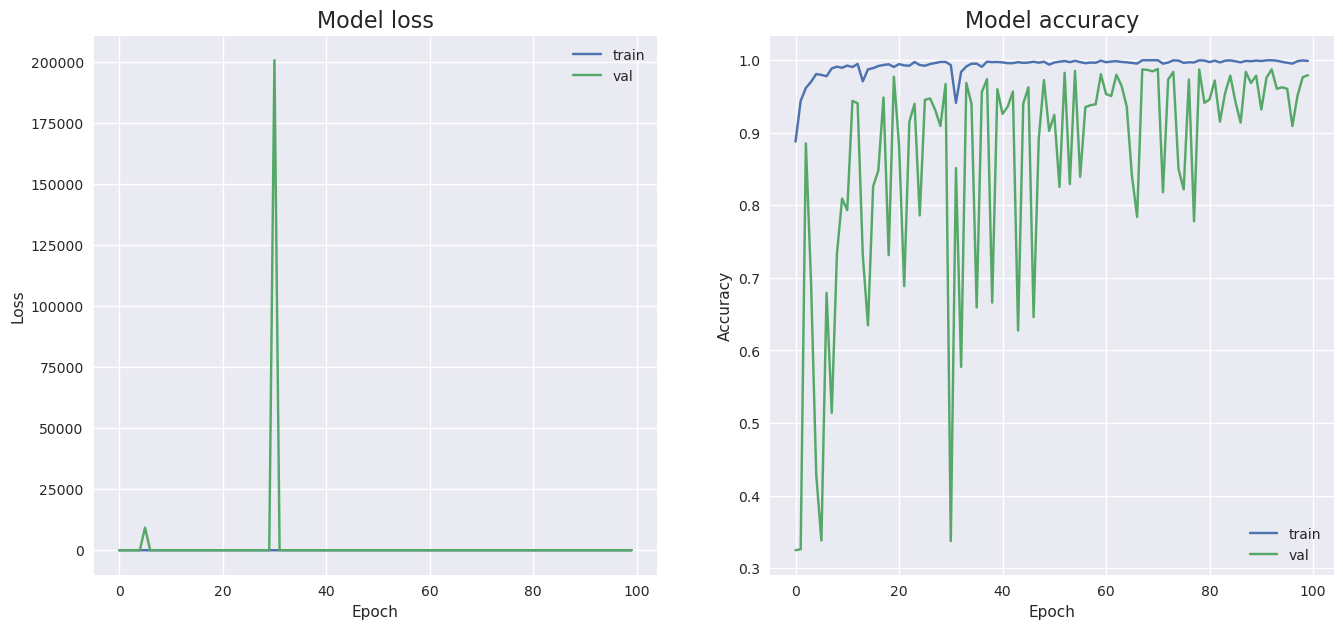

In [34]:
plt.style.use('seaborn')
plt.figure(figsize=(16,7))

plt.subplot(1,2,1)
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model loss', fontsize=16)  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'])

plt.subplot(1,2,2)
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('Model accuracy', fontsize=16)  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'val'])

plt.show()

In [35]:
y_pred_test = model_2.predict(X_test, verbose=1)
y_pred_train = model_2.predict(X_train, verbose=1)

# conversion to one hot encoding
#y_pred_test = (y_pred_test > 0.5).astype("int32")
#y_pred_train = (y_pred_train > 0.5).astype("int32")

# convert it to numerical classes
y_pred_test = np.argmax(y_pred_test, axis=1)
y_pred_train = np.argmax(y_pred_train, axis=1)

score_test = model_2.evaluate(X_test, Y_test)
print(f"Train accuracy: {history.history['accuracy'][-1]:.3f}")
print(f"Validation accuracy: {history.history['val_accuracy'][-1]:.3f}")
print(f"Test accuracy: {score_test[1]:.3f}")

47/47 [==============================] - 1s 12ms/step - loss: 0.1059 - accuracy: 0.9787
Train accuracy: 0.999
Validation accuracy: 0.979
Test accuracy: 0.979


<Axes: >

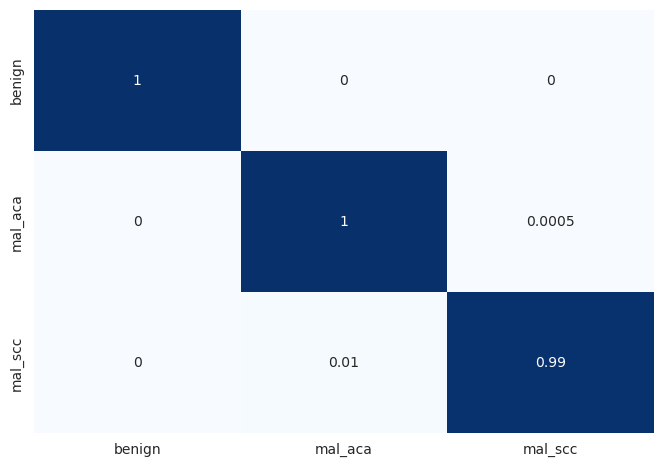

In [36]:
label_names = ['benign', 'mal_aca', 'mal_scc']


confmat = confusion_matrix(y_train, y_pred_train, normalize='true')
sn.heatmap(confmat, annot=True, cmap='Blues', cbar=False, 
           xticklabels=label_names, yticklabels=label_names)

In [37]:
from sklearn.metrics import confusion_matrix, classification_report


# Classification report for training set
classification_report_train = classification_report(y_train, y_pred_train, target_names=label_names)

# Classification report for testing set
classification_report_test = classification_report(y_test, y_pred_test, target_names=label_names)

print("Training Set Classification Report:\n")
print(classification_report_train)

print("Testing Set Classification Report:\n")
print(classification_report_test)

Training Set Classification Report:

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      4012
     mal_aca       0.99      1.00      0.99      4007
     mal_scc       1.00      0.99      0.99      3981

    accuracy                           1.00     12000
   macro avg       1.00      1.00      1.00     12000
weighted avg       1.00      1.00      1.00     12000

Testing Set Classification Report:

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00       482
     mal_aca       0.95      0.99      0.97       486
     mal_scc       0.99      0.95      0.97       532

    accuracy                           0.98      1500
   macro avg       0.98      0.98      0.98      1500
weighted avg       0.98      0.98      0.98      1500



**Mistakes**

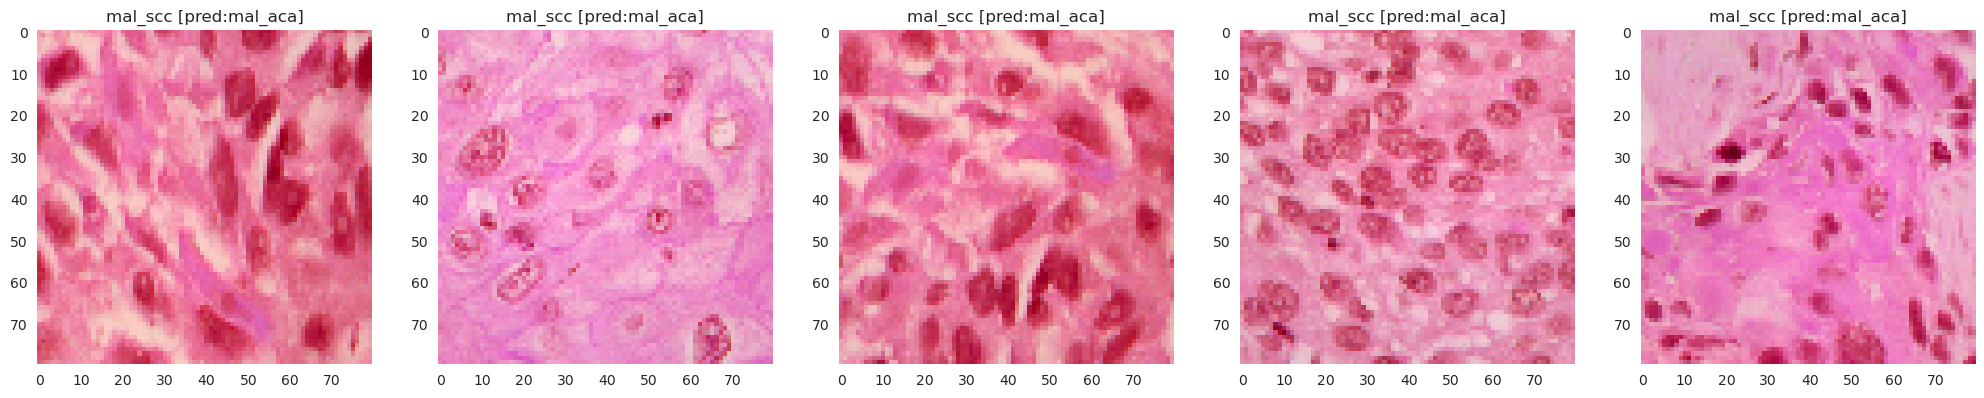

In [38]:
mistakes = np.where(y_pred_train != y_train)[0]

n = 5

plt.figure(figsize=(5 * n, 5))

# get 5 random false negatives
for i, val in enumerate(np.random.choice(mistakes, n)):

    plt.subplot(1, n, i + 1)
    plt.imshow(X_train[val])
    plt.title(f"{label_names[y_train[val]]} [pred:{label_names[y_pred_train[val]]}]", fontsize=12)
    plt.grid(None)

